# 微调
:label:`sec_fine_tuning`

在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。
我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1000万的图像和1000类的物体。
然而，我们平常接触到的数据集的规模通常在这两者之间。

假如我们想识别图片中不同类型的椅子，然后向用户推荐购买链接。
一种可能的方法是首先识别100把普通椅子，为每把椅子拍摄1000张不同角度的图像，然后在收集的图像数据集上训练一个分类模型。
尽管这个椅子数据集可能大于Fashion-MNIST数据集，但实例数量仍然不到ImageNet中的十分之一。
适合ImageNet的复杂模型可能会在这个椅子数据集上过拟合。
此外，由于训练样本数量有限，训练模型的准确性可能无法满足实际要求。

为了解决上述问题，一个显而易见的解决方案是收集更多的数据。
但是，收集和标记数据可能需要大量的时间和金钱。
例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究资金。
尽管目前的数据收集成本已大幅降低，但这一成本仍不能忽视。

另一种解决方案是应用*迁移学习*（transfer learning）将从*源数据集*学到的知识迁移到*目标数据集*。
例如，尽管ImageNet数据集中的大多数图像与椅子无关，但在此数据集上训练的模型可能会提取更通用的图像特征，这有助于识别边缘、纹理、形状和对象组合。
这些类似的特征也可能有效地识别椅子。

## 步骤

在本节中，我们将介绍迁移学习中的常见技巧:*微调*（fine-tuning）。如 :numref:`fig_finetune`所示，微调包括以下四个步骤：

1. 在源数据集（例如ImageNet数据集）上预训练神经网络模型，即*源模型*。
1. 创建一个新的神经网络模型，即*目标模型*。这将复制源模型上的所有模型设计及其参数（输出层除外）。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适用于目标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在目标模型中使用该层。
1. 向目标模型添加输出层，其输出数是目标数据集中的类别数。然后随机初始化该层的模型参数。
1. 在目标数据集（如椅子数据集）上训练目标模型。输出层将从头开始进行训练，而所有其他层的参数将根据源模型的参数进行微调。

![微调。](../img/finetune.svg)
:label:`fig_finetune`

当目标数据集比源数据集小得多时，微调有助于提高模型的泛化能力。

## 热狗识别

让我们通过具体案例演示微调：热狗识别。
我们将在一个小型数据集上微调ResNet模型。该模型已在ImageNet数据集上进行了预训练。
这个小型数据集包含数千张包含热狗和不包含热狗的图像，我们将使用微调模型来识别图像中是否包含热狗。


In [14]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### 获取数据集

我们使用的[**热狗数据集来源于网络**]。
该数据集包含1400张热狗的“正类”图像，以及包含尽可能多的其他食物的“负类”图像。
含着两个类别的1000张图片用于训练，其余的则用于测试。

解压下载的数据集，我们获得了两个文件夹`hotdog/train`和`hotdog/test`。
这两个文件夹都有`hotdog`（有热狗）和`not-hotdog`（无热狗）两个子文件夹，
子文件夹内都包含相应类的图像。


In [15]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

我们创建两个实例来分别读取训练和测试数据集中的所有图像文件。


In [16]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

下面显示了前8个正类样本图片和最后8张负类样本图片。
正如你所看到的，[**图像的大小和纵横比各有不同**]。


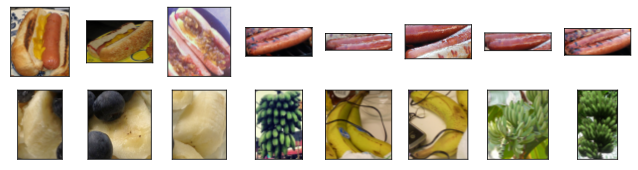

In [17]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

在训练期间，我们首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为$224 \times 224$输入图像。
在测试过程中，我们将图像的高度和宽度都缩放到256像素，然后裁剪中央$224 \times 224$区域作为输入。
此外，对于RGB（红、绿和蓝）颜色通道，我们分别*标准化*每个通道。
具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

[~~数据增广~~]


In [18]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### [**定义和初始化模型**]

我们使用在ImageNet数据集上预训练的ResNet-18作为源模型。
在这里，我们指定`pretrained=True`以自动下载预训练的模型参数。
如果你首次使用此模型，则需要连接互联网才能下载。


In [19]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

预训练的源模型实例包含许多特征层和一个输出层`fc`。
此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。
下面给出了源模型的成员变量`fc`。


In [20]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

在ResNet的全局平均汇聚层后，全连接层转换为ImageNet数据集的1000个类输出。
之后，我们构建一个新的神经网络作为目标模型。
它的定义方式与预训练源模型的定义方式相同，只是最终层中的输出数量被设置为目标数据集中的类数（而不是1000个）。

在下面的代码中，目标模型`finetune_net`中成员变量`features`的参数被初始化为源模型相应层的模型参数。
由于模型参数是在ImageNet数据集上预训练的，并且足够好，因此通常只需要较小的学习率即可微调这些参数。

成员变量`output`的参数是随机初始化的，通常需要更高的学习率才能从头开始训练。
假设`Trainer`实例中的学习率为$\eta$，我们将成员变量`output`中参数的学习率设置为$10\eta$。


In [21]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

### [**微调模型**]

首先，我们定义了一个训练函数`train_fine_tuning`，该函数使用微调，因此可以多次调用。


In [22]:
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

我们[**使用较小的学习率**]，通过*微调*预训练获得的模型参数。


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 2.00 GiB total capacity; 901.16 MiB already allocated; 0 bytes free; 922.00 MiB reserved in total by PyTorch)

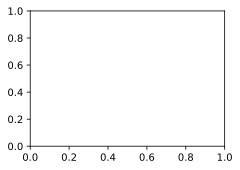

In [23]:
train_fine_tuning(finetune_net, 5e-5)

[**为了进行比较，**]我们定义了一个相同的模型，但是将其(**所有模型参数初始化为随机值**)。
由于整个模型需要从头开始训练，因此我们需要使用更大的学习率。


loss 0.433, train acc 0.815, test acc 0.854
1579.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


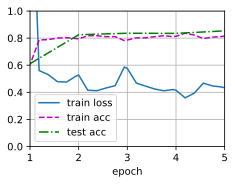

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

意料之中，微调模型往往表现更好，因为它的初始参数值更有效。

## 小结

* 迁移学习将从源数据集中学到的知识“迁移”到目标数据集，微调是迁移学习的常见技巧。
* 除输出层外，目标模型从源模型中复制所有模型设计及其参数，并根据目标数据集对这些参数进行微调。但是，目标模型的输出层需要从头开始训练。
* 通常，微调参数使用较小的学习率，而从头开始训练输出层可以使用更大的学习率。

## 练习

1. 继续提高`finetune_net`的学习率，模型的准确性如何变化？
2. 在比较实验中进一步调整`finetune_net`和`scratch_net`的超参数。它们的准确性还有不同吗？
3. 将输出层`finetune_net`之前的参数设置为源模型的参数，在训练期间不要更新它们。模型的准确性如何变化？你可以使用以下代码。


In [ ]:
for param in finetune_net.parameters():
    param.requires_grad = False

4. 事实上，`ImageNet`数据集中有一个“热狗”类别。我们可以通过以下代码获取其输出层中的相应权重参数，但是我们怎样才能利用这个权重参数？


In [ ]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape

torch.Size([1, 512])

[Discussions](https://discuss.d2l.ai/t/2894)
